## Brief Overview

### Comparison of motif similarity at embryonic stages.
To assess the similarity of developmental stages in the two species based on what TFs are important in them.
We counted motifs (PWMs) in dynamic ATAC peaks of our various developmental stages. We divided each motif's count by the total hits of the motif in all
stages and then scaled the values in each stage. 
We could then calculate the correlation between stages and thus, we created a heatmap of correlation for the developmental stages of the two species.

### Comparison of gene enrichment among WGCNA modules
To assess the similarity between two modules based on their gene members,
we used gene homology to compute an enrichment score.
We consider the total amount of gene families to be our "population", a "sample" is the gene families of one module and the "success in the population" the families of the other module. The intersection of the gene families between the two modules is the "success in the sample".
We fit those counts into a hypergometric distribution and compute the survival function (upper tail) to get a pvalue: how statistically significant is the overlap between the two modules?

### Comparison of motif enrichment among WGCNA modules / Motif enrichment per module.
Having assigned genomic regions to genes (see # BASAL and GREAT regions ),it is a simple matter to assign PWMs to genes and from there to assign PWMs to modules. The PWMs of each module are all the PWMs that were mapped inside all the BASAL regions of all the genes that belong to a module.    
In order to compare the importance of PWMs for various modules, we need to normalize these counts, since modules have varying numbers of genes and PWMs have varying promiscuities.    
To accomplish this, we divide the count of each PWM in each module by the total number of hits of the PWM (to remove the effect of PWM promiscuity)
and then standardize the values per module.
Having a standardized score per module per PWM, we can now plot it, or use it to compute the correlation between two modules.

In [61]:
import pickle
from pybedtools import BedTool as BT
import pandas as pd
import numpy as np


from scipy.stats import hypergeom
statf = hypergeom.sf

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.metrics.pairwise import pairwise_distances as PWD
from sklearn.preprocessing import scale
from math import log

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
# matplotlib can't find serif-sans on my system and throws a warning 
# every-single-time-i-plot-something
matplotlib.rcParams.update({
    'font.family':'DejaVu Sans',
    'font.sans-serif':['DejaVu Sans'],
    })
sns.set_style('white')

from collections import Counter


# Needed data:


* ### Assignment of genes to modules (WGCNA / MFUZZ)    

We use WGCNA to cluster genes by their RNA activity in various RNAseq experiments, both in developmental stages and pure tissue samples. This analysis assigns each gene in a single cluster. These clusters have names like "blue". "green" etc.
We manually explore the clusters, and by determining at which experiment the genes of the cluster seem to be differentially expressed (but also by GO analysis on each cluster), we assign more meaningful names to the clusters , like "liver", "muscle" etc. 

In [55]:
dan_cl = pd.read_csv("/path/to/Run8_dan_module_key.tab", sep='\t')
dan_cl.columns = ['geneID','clusterID','updown']
dan_cl_d = dict(dan_cl[['geneID','clusterID']].to_records(index=False))
bla_cl = pd.read_csv("/path/to/Run8_bla_module_key.tab", sep='\t')
bla_cl.columns = ['geneID','clusterID','updown']
bla_cl_d = dict(bla_cl[['geneID','clusterID']].to_records(index=False))

bla_cl.head(2)

,geneID,clusterID,updown
0,BL06687,greenyellow,+
1,BL12105,greenyellow,+


In [56]:
# The translating dictionaries
transA = {
'black' : '32 cells','blue' : 'N.tube(neurotrans.)',
'brown' : 'Gills','cyan' : 'N.tube(neurogen.)',
'darkmagenta' : 'Ovary/ Testis(translation)','darkorange' : 'Cilium',
'darkred' : 'Muscle','darkseagreen4' : '8-36hpf embryo/ Skin/ Cirri(memb. synt.)',
'darkslateblue' : '8hpf embryo(transcription, spliceosome)','darkturquoise' : '36hpf embryo',
'green' : 'Eggs/ 32 cells(cell cycle)','greenyellow' : 'Hepatic(lipid catabolism)',
'lavenderblush3' : 'Cirri/ PreMet.larvae(muscle contraction)','lightpink4' : '15hpf embryo',
'magenta' : 'Skin','navajowhite2' : 'Skin/ Gills/ Cirri(immune response)',
'palevioletred3' : 'Ovary/ Eggs','pink' : 'Gut',
'plum1' : 'Gut/ Hepatic','plum2' : 'Proteasome',
'red' : 'PreMet.larvae','salmon' : 'Cirri(memb. synt.)',
'sienna3' : 'Hepatic','thistle2' : 'Gills/ PreMet larvae',
'turquoise' : '(ATP synth., mitochondrion)'}
transZ = {
 'bisque4' : "7dpf larvae",'black' : "Ovary/ Sperm",
'blue' : "Brain",'brown' : "Cilium",
'brown4' : "Liver(carboxi.met./ lipid trans)",'coral2' : "ATP synt./ mitochondrion",
'darkgreen' : "Intestine",'darkgrey' : "RNA, ribosome, proteasome",
'darkmagenta' : "Translation, ribosome, RNA bin.",'darkorange' : "Muscle",
'darkred' : "Liver(oxi-red.proc./ hemostasis)",'darkseagreen4' : "12-26hpf embryo/ Skin",
'darkslateblue' : "Gills / Kidney(immune response)",'green' : "Spliceosome",
'honeydew1' : "12-26hpf embryo",'ivory' : "Eye",'lightcyan' : "Heart",
'lightgreen' : "Pancreas/ Testis",'magenta' : "Gills",'pink' : "Skin",
'salmon' : "20-26hpf embryo",'yellow4' : "Kidney",'yellowgreen' : "Gills/ Skin"}

* ### Assignment of genome regions to genes (GREG tables)
    
We assign a BASAL region to each gene, it starts from its TSS and extends 5kb upstream and 1kb downstream, or untill it encounters another TSS.

In [57]:
# gene to "gene region" connection
dan_greg = pd.read_csv("/path/to/zebra_BASAL.bed", sep='\t', header=None)
dan_greg.columns = ['chrom','start','end','geneID','strand']
dan_greg['score'] = 0
dan_greg = dan_greg[['chrom','start','end','geneID','score','strand']]

bla_greg = pd.read_csv("/path/to/amphi_BASAL.bed", sep='\t', header=None)
bla_greg.columns = ['chrom','start','end','geneID','strand']
bla_greg['score'] = 0
bla_greg = bla_greg[['chrom','start','end','geneID','score','strand']]

bla_greg.head(2)

,chrom,start,end,geneID,score,strand
0,Sc0000000,20509,26510,BL09450,0,+
1,Sc0000000,164904,170905,BL10006,0,+


* ### TF Motifs mapped in the genome


In [58]:
dan_motif_bed = BT("/path/to/zebra_danRer10_pwm_hits.bed").sort()
bla_motif_bed = BT("/path/to/amphi_pwm_hits.bed").sort()

In [63]:
# unique numerical IDs for PWM families
SFDu = pickle.load(open("/path/to/sFDu.pickle","rb"))
SF = pd.read_csv("/path/to/SF.csv", sep='\t', index_col=0)
SF.columns = ['PWMname','FamName','FamID']
SF.sample(2)

,PWMname,FamName,FamID
u,,,
134,Homeodomain_POU_Average_56,14994;18362;20868,Pou3f2;Pou2f1;pou5f3
92,Homeodomain_Average_495,2267;2301;20883,Barx1;Msx2;msxc


* ### Grouping of genes into homology-families       

We have in our disposal a precomputed table where genes of various species
are separated into homologous families.

Each row is a family, each column a species. 
The paralogues of each species are separated with ":" so when we load this dataset
we split the strings into lists.

In [60]:
genefams = pd.read_csv("/path/to/the_gene_fams_table.txt",
                      sep='\t')
fam_of = {}
for rowi,row in genefams[['Bla']].dropna().iterrows():
    for gene in row.Bla.split(":"):
        fam_of[gene]= rowi
for rowi,row in genefams[['Dre']].dropna().iterrows():
    for gene in row.Dre.split(":"):
        fam_of[gene]= rowi

* ### Miscellaneous

In [ ]:
amphi_stages = ['8','15','36','60','hep']
zebra_stages = ['dome','shield','80epi','8som','24h','48h']

## The analysis

Map the module names to genes on the GREG table:

In [7]:
dan_greg['cluster'] = dan_greg.geneID.map(dan_cl_d)
dan_greg = dan_greg[~dan_greg.cluster.isnull()]

bla_greg['cluster'] = bla_greg.geneID.map(bla_cl_d)
bla_greg = bla_greg[~bla_greg.cluster.isnull()]

bla_greg.head(2)

,chrom,start,end,geneID,score,strand,cluster
0,Sc0000000,20509,26510,BL09450,0,+,blue
1,Sc0000000,164904,170905,BL10006,0,+,blue


Next, we do a Left Outter Join (LOJ) of the GREG table and the motif table.
This essentially maps motifs to genes.

In the resulting loj tables, the first 6 columns refer to a gene's BASAL region,
and they are repeated for as many PWMs were found in said region,
each row is a mapping of onw PWM to one gene.

We also map the PWM unique IDs on this table ('fam')

In [8]:
dan_loj = (BT()
        .from_dataframe(dan_greg[['chrom','start','end','cluster','score','strand']])
        .sort()
        .intersect(dan_motif_bed, loj=True, nonamecheck=True, sorted=True)
        ).to_dataframe()[['chrom','start','end','name','score','strand','blockCount']]

dan_loj = dan_loj[dan_loj.blockCount != '.']
dan_loj['fam'] = dan_loj.blockCount.map(SFDu)
dan_loj = dan_loj[~dan_loj['fam'].isnull()]
dan_loj.fam = dan_loj.fam.astype(int)

bla_loj = (BT()
        .from_dataframe(bla_greg[['chrom','start','end','cluster','score','strand']])
        .sort()
        .intersect(bla_motif_bed, loj=True, nonamecheck=True, sorted=True)
        ).to_dataframe()[['chrom','start','end','name','score','strand','blockCount']]

bla_loj = bla_loj[bla_loj.blockCount != '.']
bla_loj['fam'] = bla_loj.blockCount.map(SFDu)
bla_loj = bla_loj[~bla_loj['fam'].isnull()]
dan_loj.fam = dan_loj.fam.astype(int)
bla_loj.head(2)

,chrom,start,end,name,score,strand,blockCount,fam
1,Sc0000000,20509,26510,blue,0,+,C2H2_ZF_Average_244,92.0
5,Sc0000000,20509,26510,blue,0,+,ARID_BRIGHT_RFX_M4343_1.02,179.0


### Comparison of gene enrichment among WGCNA modules

We want to get a measure of how similar a module from one species is to a module of the other species.

To do this, we calculate an enrichment score (The survival function of a hypergeometric distribution). We consider the Population as the total amount of gene families,
a sample is the gene families of one module and the success in the population the families of the other module. The intersection of the gene families between the two modules is the
success in the sample.

In [10]:
gimme_fams = lambda g: [fam_of.get(x) for x in g.geneID.tolist()]
gene_POP = len(genefams)

fishes = pd.DataFrame()

for gn,g  in dan_cl.groupby('clusterID'):
    for bgn,bg  in bla_cl.groupby('clusterID'):
        
        fams = set(gimme_fams(g))
        bfams = set(gimme_fams(bg))
        
        gene_SS = len(fams) # number of zebra families here (Sample Size)
        gene_SIP = len(bfams) # number of amphi gene families here (Success in Population)
        gene_SIS = len(bfams.intersection(fams)) # Success in Sample
        
        if gene_SIS>0:
            fish = statf(gene_SIS,  gene_POP,  gene_SS, gene_SIP)
        else:
            fish =1 
            
        fishes.loc[transZ[gn], transA[bgn]] = fish

In [65]:
# we get the -log transformation of the pvalues and clip them
mfishes = fishes.applymap(lambda x: -log(x,10) ).copy().clip(upper=25,lower=0)

# What this table looks like
mfishes.iloc[:3,:3]

,32 cells,N.tube(neurotrans.),Gills
7dpf larvae,1.086317,2.297411,1.101249
Ovary/ Sperm,17.625959,0.222190,0.000039
Brain,2.940318,25.000000,0.497692


In [11]:
# We manually get the clustering linkage (instead of relying on the seaborn library)
# this allowed a bit more flexibility so we could try various clustering methods
# we can also easily reuse the linkage objects in further heatmaps
linkage_fisher_rows = hc.linkage(sp.distance.squareform(
                                PWD(  mfishes.values, metric='euclidean'), 
                                checks=False), method='complete')
linkage_fisher_cols = hc.linkage(sp.distance.squareform(
                                PWD(  mfishes.T.values, metric='euclidean'), 
                                checks=False), method='complete')

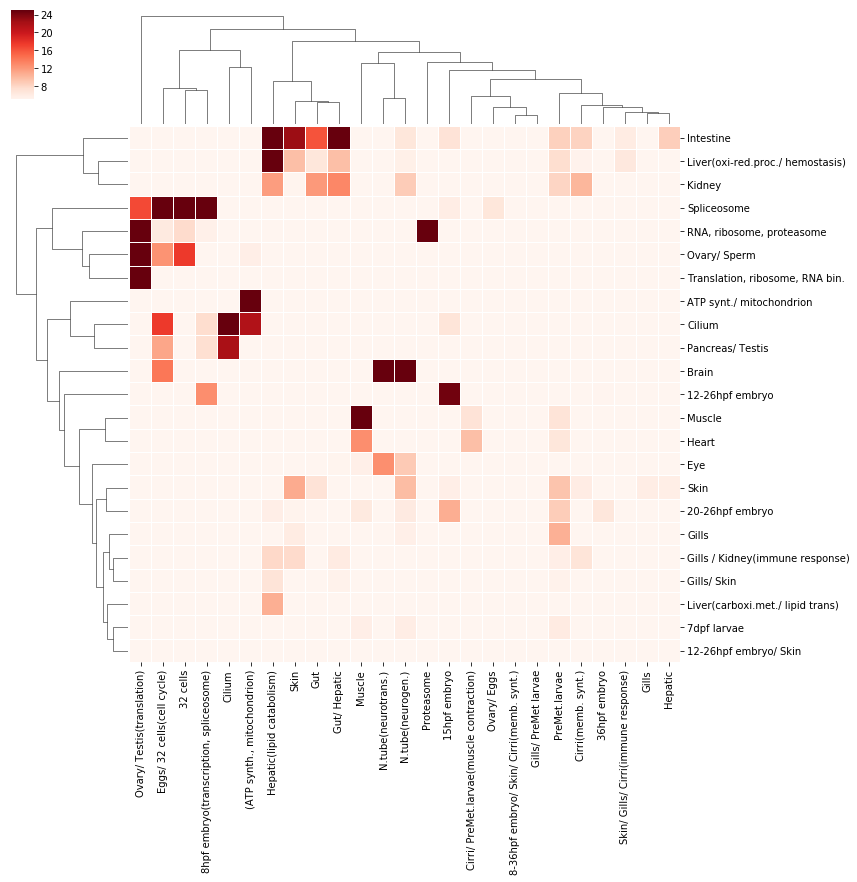

In [12]:
# We can finally plot the table as a heatmap:
geneHM = sns.clustermap( mfishes,
                      row_linkage = linkage_fisher_rows,
                      col_linkage = linkage_fisher_cols,
                      linewidths=0.01,
                      figsize =(12,12),
                      cmap='Reds',
                      vmax=25, vmin=5
                      )

_ = plt.setp(geneHM.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

### Comparison of motif enrichment among WGCNA modules

We now want to compare the modules based on their PWM content.
We will do that using the LOJ tables that we created above.

In the following cells, the tables bla_ and dan_
contain a count of instances per PWM family per module:

In [15]:
blawillit = [Counter(g.fam) for gn,g in bla_loj.groupby("name")]
bladidit = pd.DataFrame(blawillit)   
bladidit = bladidit.fillna(0)   

clustorder = [transA[gn] for gn,g in bla_loj.groupby("name")]

bladidit.index = clustorder
bla_ = bladidit.copy()
bla_.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,246.0,247.0,248.0,249.0,250.0,251.0,252.0,253.0,255.0,256.0
32 cells,19.0,48,17.0,100,29,80,317,118,22.0,265,...,251,10.0,959,20.0,19.0,44,24,25.0,63,180
N.tube(neurotrans.),18.0,59,14.0,84,24,90,388,153,17.0,269,...,248,13.0,876,13.0,21.0,50,16,31.0,48,169
Gills,26.0,68,14.0,109,22,94,369,122,20.0,250,...,207,11.0,842,22.0,24.0,54,10,60.0,61,226
N.tube(neurogen.),14.0,49,18.0,75,24,80,323,136,15.0,276,...,253,4.0,799,19.0,27.0,52,25,46.0,65,195
Ovary/ Testis(translation),15.0,58,14.0,103,22,95,322,147,15.0,256,...,294,18.0,1022,23.0,18.0,60,37,32.0,76,195


In [16]:
danwillit = [Counter(g.fam) for gn,g in dan_loj.groupby("name")]
dandidit = pd.DataFrame(danwillit)   
dandidit = dandidit.fillna(0)   

clustorder = [transZ[gn] for gn,g in dan_loj.groupby("name")]

dandidit.index = clustorder
dan_ = dandidit.copy()
dan_.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,255,256
7dpf larvae,9,60,6.0,43,19,48,223,86,10,204,...,122,4.0,339,7.0,10,34,4.0,20,50,64
Ovary/ Sperm,35,106,16.0,141,66,170,519,230,30,342,...,275,7.0,1158,37.0,32,91,22.0,30,121,204
Brain,85,384,41.0,393,160,484,1894,691,89,1611,...,1080,36.0,3331,92.0,115,327,97.0,134,452,681
Cilium,27,136,34.0,224,96,257,727,345,57,516,...,400,13.0,1679,50.0,42,130,40.0,50,185,316
Liver(carboxi.met./ lipid trans),2,2,1.0,2,4,8,26,16,3,38,...,21,0.0,69,0.0,5,9,2.0,1,10,13


We get the intersection of the found families, this will allign the columns of the 
two tables and ignore the couple of families that were not found in one species or the other:

In [21]:
dan_allfams = set(dandidit.columns)
bla_allfams = set(bladidit.columns)
allfams = dan_allfams.intersection(bla_allfams)

#### Normalizing and scaling

In [25]:
# We divide the count by the sum and then scale the rows
btp = (bla_.loc[:,allfams]/bla_.loc[:,allfams].sum())
btp.loc[:,:] = scale(btp, axis=1)

dtp =  (dan_.loc[:,allfams]/dan_.loc[:,allfams].sum())
dtp.loc[:,:] = scale(dtp, axis=1)

In [31]:
# We add a prefix to the module names:
cbtp = btp.copy()
cbtp.index = ["a_"+x for x in  btp.index.values]
cdtp = dtp.copy()
cdtp.index = ["z_"+x for x in  dtp.index.values]

In [67]:
dtp.head(2)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,246.0,247.0,248.0,249.0,250.0,251.0,252.0,253.0,255.0,256.0
7dpf larvae,-0.228957,1.758468,0.433453,-0.268538,-0.010196,-0.374406,0.614127,0.440445,-0.159157,1.127273,...,0.519312,0.310246,-0.345763,-0.968951,-0.027625,0.224661,-1.828846,1.692278,0.374413,-0.297538
Ovary/ Sperm,1.303339,-0.462481,0.124485,0.074940,1.004065,0.324534,-0.389361,0.154147,-0.234837,-1.415519,...,-0.701480,-2.119472,0.161726,1.452254,0.416424,-0.206806,-1.239889,-1.362140,-0.533073,-0.153409


In [66]:
cdtp.head(2)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,246.0,247.0,248.0,249.0,250.0,251.0,252.0,253.0,255.0,256.0
z_7dpf larvae,-0.228957,1.758468,0.433453,-0.268538,-0.010196,-0.374406,0.614127,0.440445,-0.159157,1.127273,...,0.519312,0.310246,-0.345763,-0.968951,-0.027625,0.224661,-1.828846,1.692278,0.374413,-0.297538
z_Ovary/ Sperm,1.303339,-0.462481,0.124485,0.074940,1.004065,0.324534,-0.389361,0.154147,-0.234837,-1.415519,...,-0.701480,-2.119472,0.161726,1.452254,0.416424,-0.206806,-1.239889,-1.362140,-0.533073,-0.153409


#### Plotting

Our two tables now contain identical columns so we can concatenate them and 
cluster them all together. We let the plotting library do the clustering here
since it is not very important.

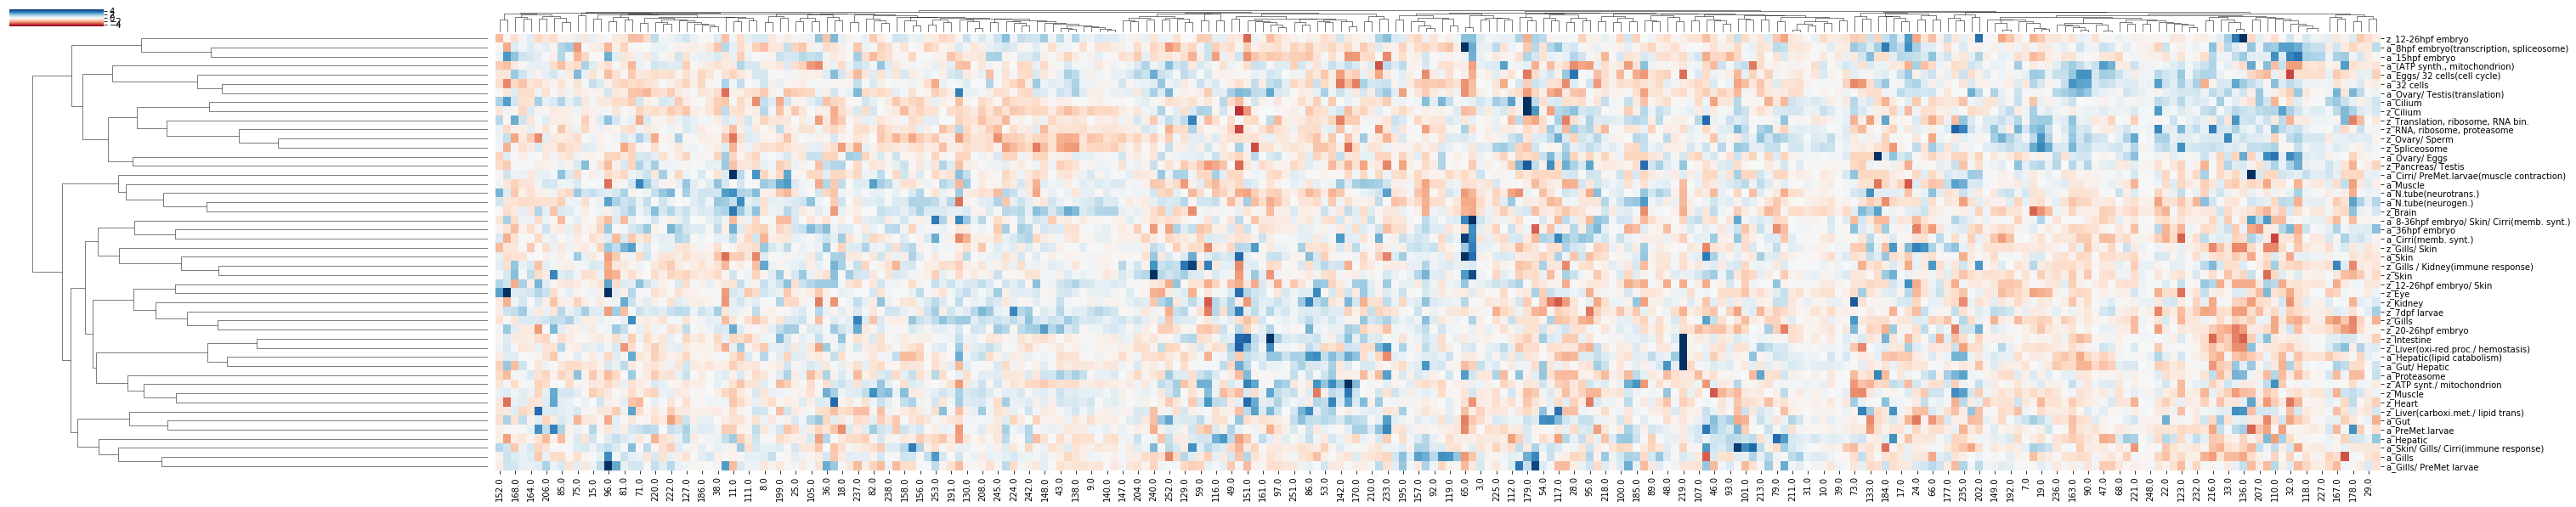

In [32]:

rawcg = sns.clustermap(pd.concat([cbtp,cdtp]),
                       metric='correlation',
                       method='average',
                        figsize=(50,10),
                      linewidths=0,
                       cmap = 'RdBu',
                      vmin=-5, vmax=5)
                   
_ = plt.setp(rawcg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

### Pairwise comparisons of modules based on the PWMs

We compute the pairwise correlations (over the PWM 'space') of the modules,
and then plot using the linkage from the gene-based clustering:

In [33]:
dists =  pd.DataFrame(PWD(dtp,btp, metric="correlation"))

dists.columns = btp.index
dists.index = dtp.index

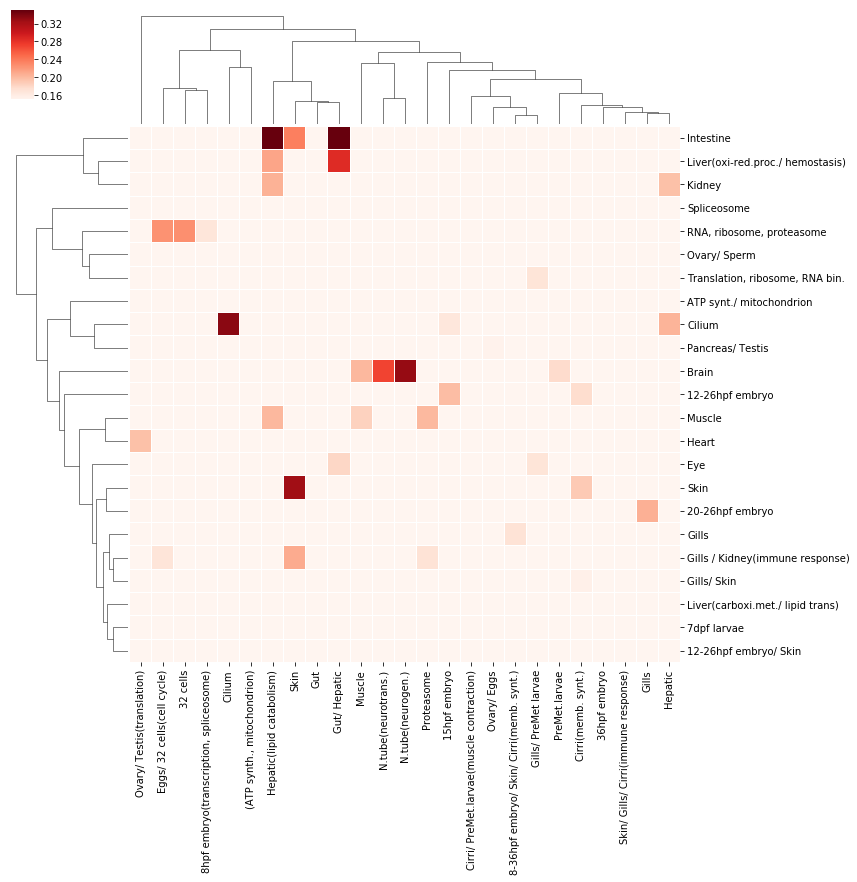

In [34]:
cg = sns.clustermap( 1-dists, 
                    row_linkage=linkage_fisher_rows, 
                    col_linkage=linkage_fisher_cols,
                    linewidths=0.01,
                    figsize =(12,12),
                    vmax=0.35,
                    vmin=0.15,
                    cmap = 'Reds'
                   )

_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

###  Motif enrichment per module.

In [35]:
# a function to help us find interesting cases
def score(l1, l2, p = 0.98):
    """
        Taken from:
        https://github.com/ragrawal/measures/blob/master/measures/rankedlist/RBO.py
        Calculates Ranked Biased Overlap (RBO) score. 
        l1 -- Ranked List 1
        l2 -- Ranked List 2
    """
    if l1 == None: l1 = []
    if l2 == None: l2 = []
    
    sl,ll = sorted([(len(l1), l1),(len(l2),l2)], key=lambda x: x[0])
    s, S = sl
    l, L = ll
    if s == 0: return 0

    # Calculate the overlaps at ranks 1 through l 
    # (the longer of the two lists)
    ss = set([]) # contains elements from the smaller list till depth i
    ls = set([]) # contains elements from the longer list till depth i
    x_d = {0: 0}
    sum1 = 0.0
    for i in range(l):
        x = L[i]
        y = S[i] if i < s else None
        d = i + 1
        
        # if two elements are same then 
        # we don't need to add to either of the set
        if x == y: 
            x_d[d] = x_d[d-1] + 1.0
        # else add items to respective list
        # and calculate overlap
        else: 
            ls.add(x) 
            if y != None: ss.add(y)
            x_d[d] = x_d[d-1] + (1.0 if x in ss else 0.0) + (1.0 if y in ls else 0.0)     
        #calculate average overlap
        sum1 += x_d[d]/d * pow(p, d)
        
    sum2 = 0.0
    for i in range(l-s):
        d = s+i+1
        sum2 += x_d[d]*(d-s)/(d*s)*pow(p,d)

    sum3 = ((x_d[l]-x_d[s])/l+x_d[s]/s)*pow(p,l)

    # Equation 32
    rbo_ext = (1-p)/p*(sum1+sum2)+sum3
    return rbo_ext

z_Brain a_N.tube(neurotrans.)


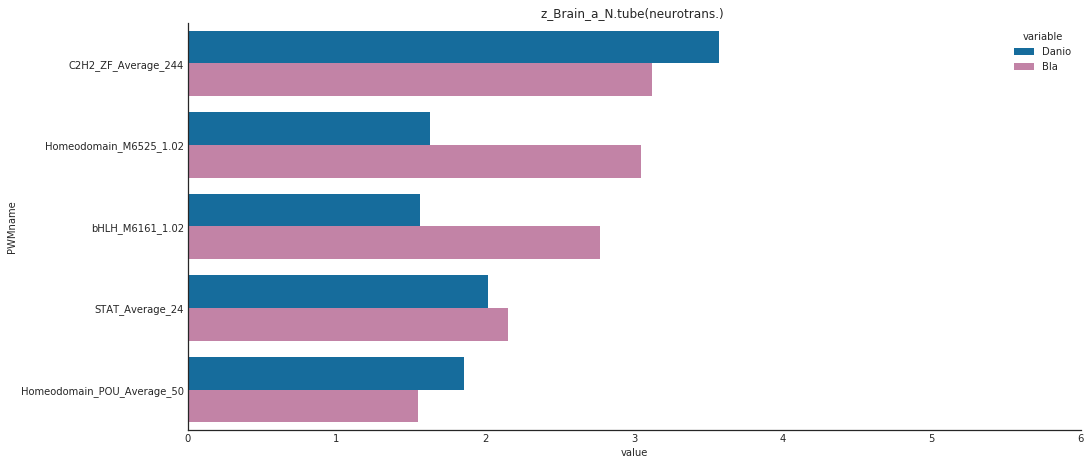

z_Cilium a_Cilium


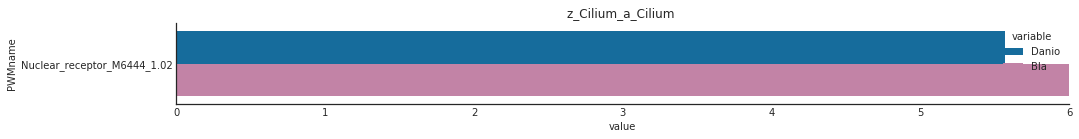

z_Intestine a_Hepatic(lipid catabolism)


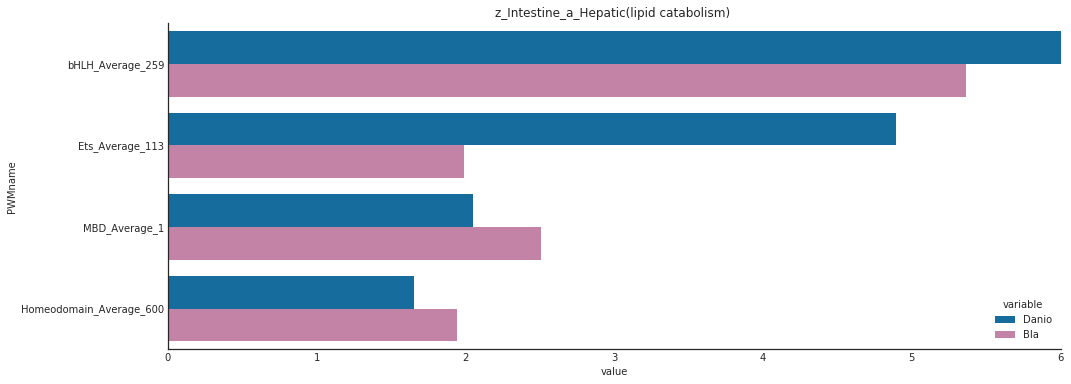

z_Intestine a_Gut/ Hepatic


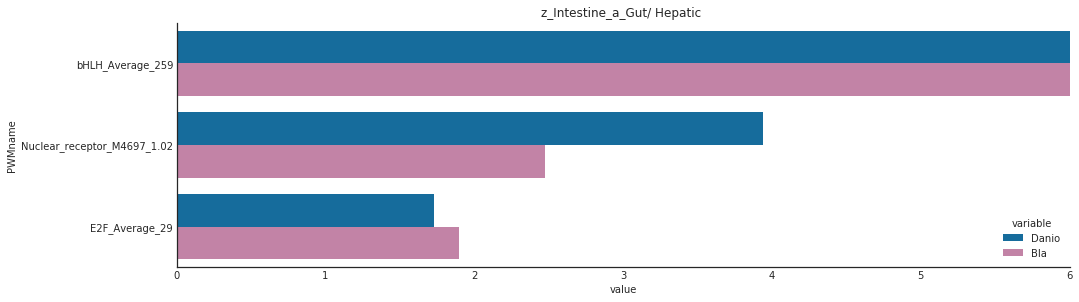

z_Translation, ribosome, RNA bin. a_PreMet.larvae


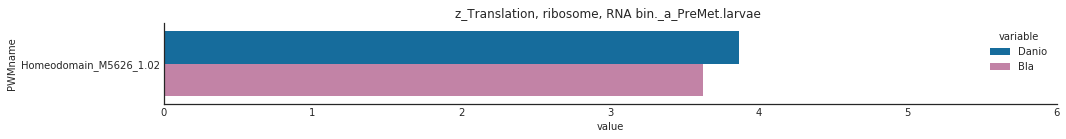

z_Muscle a_Muscle


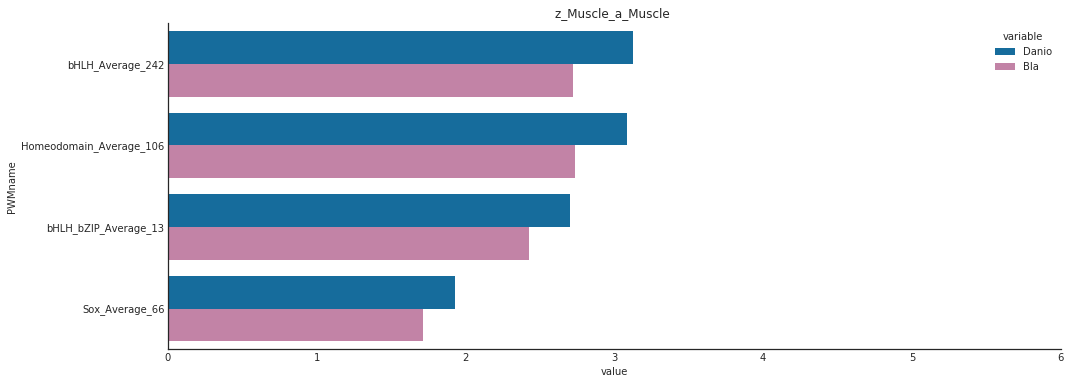

z_Liver(oxi-red.proc./ hemostasis) a_Hepatic(lipid catabolism)


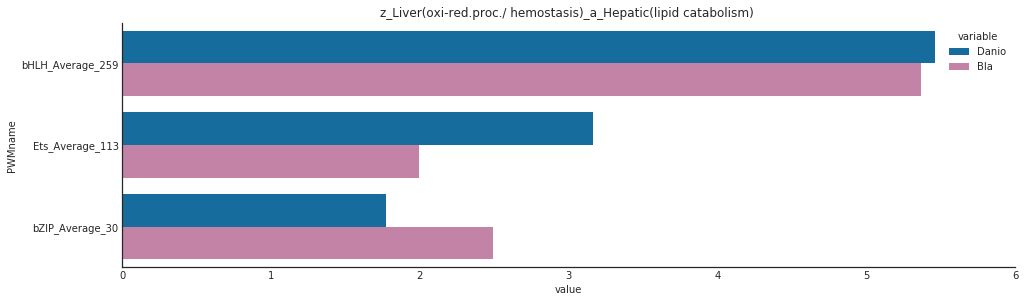

z_Liver(oxi-red.proc./ hemostasis) a_Gut/ Hepatic


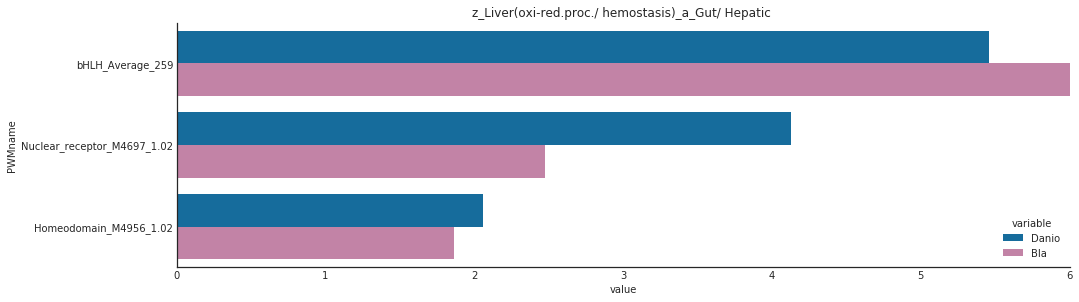

z_Pancreas/ Testis a_Cilium


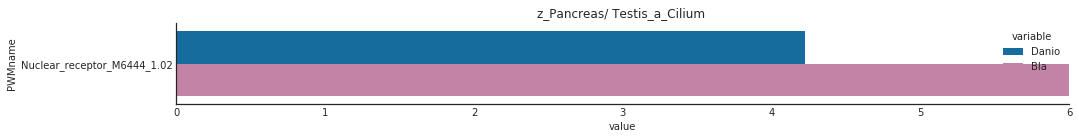

z_Skin a_8-36hpf embryo/ Skin/ Cirri(memb. synt.)


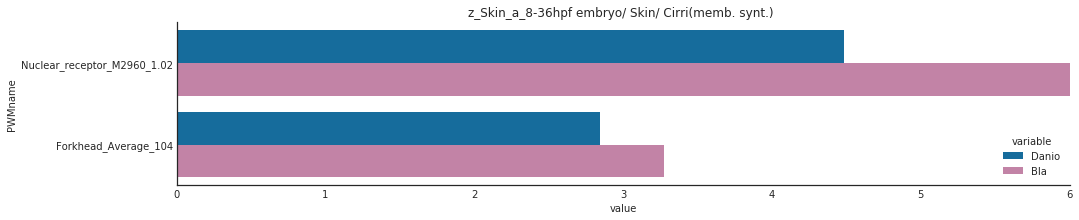

z_Skin a_Skin


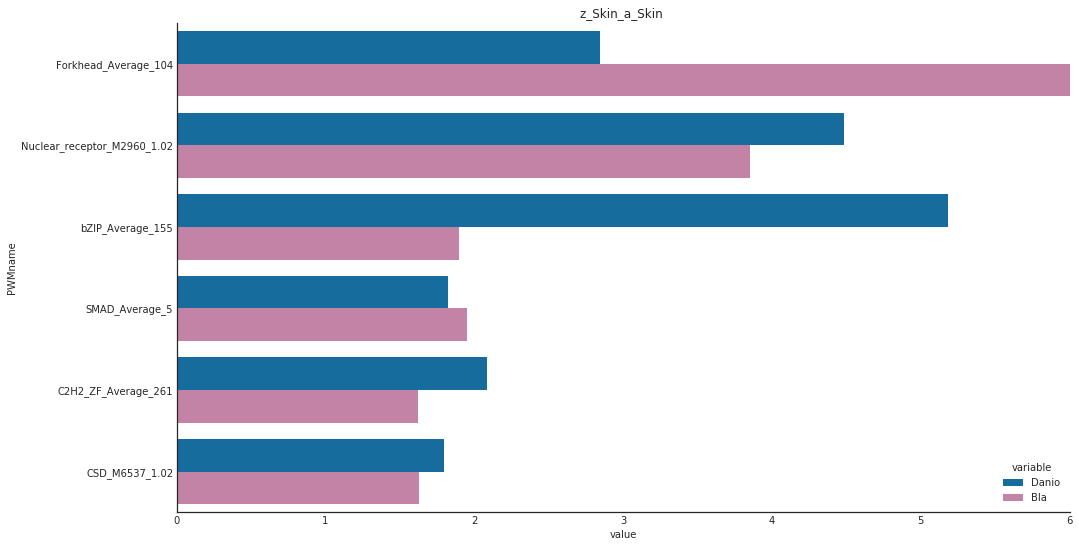

z_Gills/ Skin a_8-36hpf embryo/ Skin/ Cirri(memb. synt.)


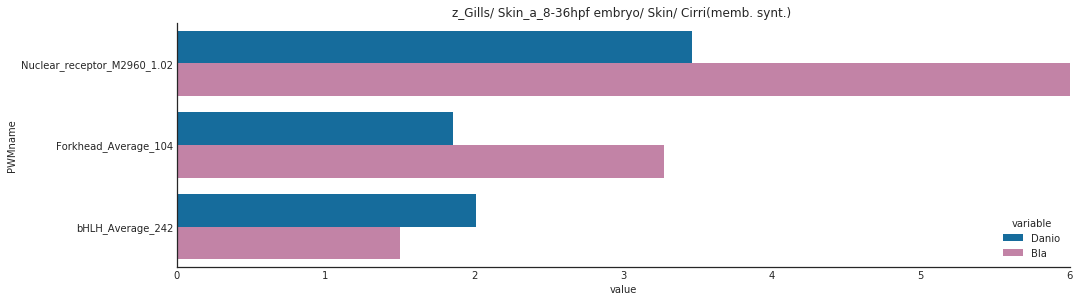

z_Gills/ Skin a_36hpf embryo


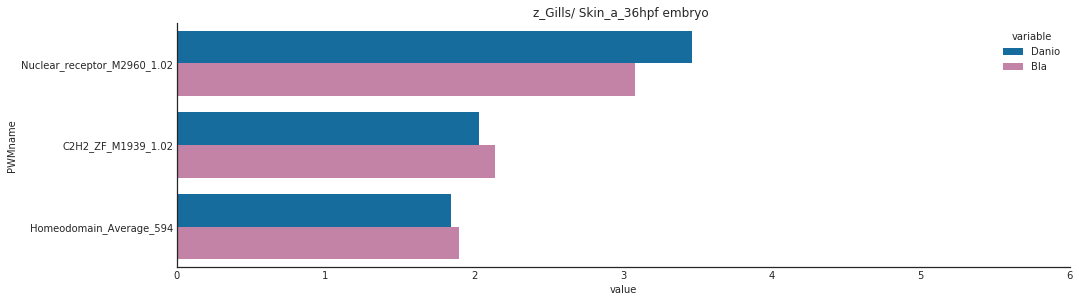

In [54]:
for drown, drow in cdtp.iterrows():
    for brown, brow in cbtp.iterrows():
        # We will compute the RBO score for every pair of modules
        ld = drow.sort_values(ascending=False).index.values
        lb = brow.sort_values(ascending=False).index.values
        rbo = score(ld,lb, 0.85)
        
        # if this score is >0.25 we'll plot them
        if rbo >0.25:
            print(drown, brown)
            
            # Get the PWM families that are "enriched" in this module
            # where enriched means zscore>1.5
            d = cdtp.loc[drown,:].sort_values(ascending=False)
            dset = set(d[d>1.5].index.values)
            # same for the other module
            b = cbtp.loc[brown,:].sort_values(ascending=False)
            bset = set(b[b>1.5].index.values)
            # Get the commonly enriched ones:
            gset = dset.intersection(bset)
            # get the human name for the family
            gee = SF.loc[gset].drop_duplicates(subset='FamID').copy()
            gee['Danio'] = gee.index.to_series().map(d.loc[gset])
            gee['Bla'] = gee.index.to_series().map(b.loc[gset])
            tp = gee[['PWMname','Danio','Bla']]
            
            
            plt.figure(figsize=(16,1.5*len(gset))) # keep the height of the bars consistent 
            
            order = tp.loc[tp.sum( axis=1).sort_values(ascending=False).index,'PWMname'].values
            sns.barplot(data=pd.melt(tp,id_vars='PWMname'), x='value',y='PWMname', hue='variable', order=order,
                       palette={'Danio':'#0072b2','Bla':'#cc79a7'})
            
            title = "{}_{} ".format(drown, brown)
            plt.title(title)
            sns.despine()
            plt.xlim((0,6))
            
            plt.show()